In [ ]:
from lle import LLE, ObservationType
import marl
from marl import Experiment, Runner
from marlenv import Episode

env = LLE.level(6).state_type(ObservationType.NORMALIZED_STATE).builder().time_limit(78).build()
agent = marl.agents.RandomAgent(env)

def get_trajectories(exp: Experiment, time_step: int):
    res = []
    for i, run in enumerate(exp.runs):
        seed = Runner.get_test_seed(time_step, 0)
        res.append((run.seed, exp.replay_episode(i, time_step, seed).episode))
    res = sorted(res, key=lambda x: x[0])
    return [x[1] for x in res]

# Generate trajectories

In [2]:
episodes = dict[str, list[Episode]]()

## Random agent

In [3]:
res = []
for i in range(30):
    obs, state = env.reset()
    is_terminal = False
    episode = Episode.new(obs, state)
    while not is_terminal:
        action = agent.choose_action(obs)
        step = env.step(action)
        episode.add(step, action)
        is_terminal = step.is_terminal
        obs = step.obs
    res.append(episode)
episodes["random"] = res

## PBRS

In [4]:
res = list[tuple[int, Episode]]()
exp = marl.Experiment.load("logs/pbrs-baseline")
for i, run in enumerate(exp.runs):
    res.append((run.seed, exp.replay_episode(i, 1_000_000, 0).episode))
res = sorted(res, key=lambda x: x[0])
episodes["pbrs"] = [x[1] for x in res]

## Baseline

In [5]:
res = list[tuple[int, Episode]]()
exp = marl.Experiment.load("logs/baseline-vdn")
for i, run in enumerate(exp.runs):
    res.append((run.seed, exp.replay_episode(i, 1_000_000, 0).episode))
res = sorted(res, key=lambda x: x[0])
episodes["baseline"] = [x[1] for x in res]

# Cleanup the states
- Pad all the episodes to the same length
- Only keep the location of each agent

In [ ]:
import numpy as np

# Padding
maxlen = 0
for e in episodes.values():
    maxlen = max(maxlen, max(len(e) for e in e))
for es in episodes.values():
    for i, e in enumerate(es):
        es[i] = e.padded(maxlen)
print("Maxlen:", maxlen)

# Gather the states
all_states = dict[str, np.ndarray]()
for name, es in episodes.items():
    states = np.array([e.all_states for e in es])
    # states = states[:, :, :8] # Only keep the locations of agents
    states = states.reshape(states.shape[0], -1)
    all_states[name] = states

Maxlen: 78


# Fit PCA

In [7]:
from sklearn import decomposition

pca = decomposition.PCA(n_components=2)
pca_states = np.concat(list(all_states.values()))
print(pca_states.shape)
pca.fit(states)

(90, 1264)


PCA(n_components=2)

# Plot PCA transformation

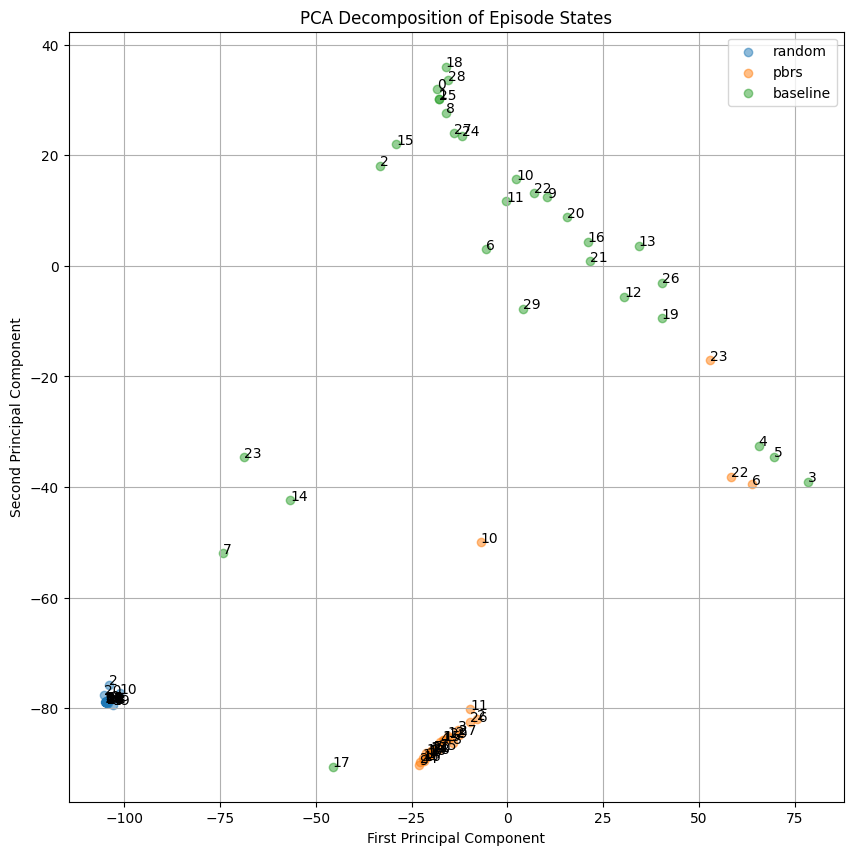

In [8]:
import matplotlib.pyplot as plt

# -- TODO:
# - Regarder en quoi ces policies sont effectivement identiques ou non (longueur, gemmes, etc)
# - Essayer avec T-SNE

plt.figure(figsize=(10, 10))
plt.xlabel('First Principal Component')
plt.ylabel('Second Principal Component')
plt.title('PCA Decomposition of Episode States')

for name, states in all_states.items():
    states_pca = pca.transform(states)
    plt.scatter(states_pca[:, 0], states_pca[:, 1], alpha=0.5, label=name)
    # Annotate each point with its ID
    for seed, state in enumerate(states_pca):
        plt.annotate(str(seed), (state[0], state[1]))


plt.grid(True)
plt.legend()
plt.savefig("pca.png")
plt.show()